In [1]:
# Load symbolicregression model

import torch
import os, sys
import symbolicregression
import sympytorch
import requests
from sympy.core.rules import Transform

model_path = "ckpt/model.pt" 
try:
    if not os.path.isfile(model_path): 
        print("Downloading model...")
        url = "https://dl.fbaipublicfiles.com/symbolicregression/model1.pt"
        r = requests.get(url, allow_redirects=True)
        open(model_path, 'wb').write(r.content)
    if not torch.cuda.is_available():
        model = torch.load(model_path, map_location=torch.device('cpu'))
    else:
        model = torch.load(model_path)
        model = model.cuda()
    print(model.device)
    print("Model successfully loaded!")

except Exception as e:
    print("ERROR: model not loaded! path was: {}".format(model_path))
    print(e)    
    
est = symbolicregression.model.SymbolicTransformerRegressor(
                        model=model,
                        max_input_points=10001,
                        n_trees_to_refine=100,
                        rescale=True
                        )

cuda:0
Model successfully loaded!


In [2]:
# from transformers import AutoTokenizer
# CONTEXT_LENGTH = 256
# tokenizer = AutoTokenizer.from_pretrained("xhyi/PT_GPTNEO350_ATG") 
# tokenizer.pad_token = tokenizer.eos_token
# from transformers import AutoModelForCausalLM, TrainingArguments, Trainer
# model = AutoModelForCausalLM.from_pretrained("datasets/normalize_symbolic_regression_results_20231215/gptneo-350m-5500.model")


from transformers import T5Tokenizer, DataCollatorForSeq2Seq
from transformers import T5ForConditionalGeneration, Seq2SeqTrainingArguments, Seq2SeqTrainer

# Load the tokenizer, model, and data collator
MODEL_NAME = "google/flan-t5-base"

tokenizer = T5Tokenizer.from_pretrained(MODEL_NAME)
model = T5ForConditionalGeneration.from_pretrained("datasets/normalize_symbolic_regression_results_flant5_20231219/flant5-base-36000-loss0.097.model")
data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer, model=model)

/home/mcwave/anaconda3/envs/symbolic/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thouroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


t**3/3 - t**2 + 2*t

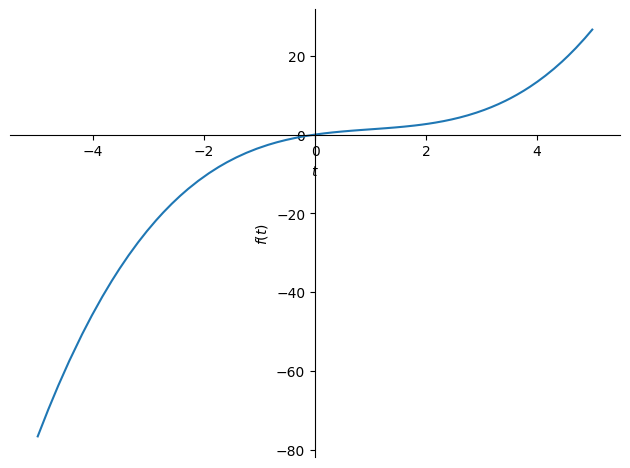

In [7]:
import numpy as np
import sympy as sp
from sympy import sympify, lambdify, symbols, integrate, Interval, Symbol, I, S, oo, plot
from IPython.display import display

# Compute integration
f = sympify("x**2-x*2+2")
#f = sympify("x*cos(x)")
x, t = symbols(['x','t'])

fi = integrate(f, x)
display(fi)
plot(fi, (x, -5, 5))

# Generate data for symbolic regression
fl = lambdify((x), fi, "numpy")
xs = np.arange(-5, 5, 0.001)
ys = fl(xs)

In [9]:
##Example of data
xs = np.reshape(xs, (len(xs),1))
ys = np.reshape(ys, (len(ys),1))
est.fit(xs,ys)

replace_ops = {"add": "+", "mul": "*", "sub": "-", "pow": "**", "inv": "1/"}
model_str = est.retrieve_tree(with_infos=True)["relabed_predicted_tree"].infix()
for op,replace_op in replace_ops.items():
    model_str = model_str.replace(op,replace_op)

raw_expr = sp.parse_expr(model_str)
x_0, t = symbols(['x_0', 't'])
raw_expr = raw_expr.subs(x_0, t)
display(raw_expr)

expr = sp.expand(raw_expr)
rounded_expr = expr.xreplace(Transform(lambda x: x.round(2), lambda x: isinstance(x, sp.Float)))
display(rounded_expr)
print(rounded_expr)

# Encode some input text
prompt = str(rounded_expr) + " entail"
input_ids = tokenizer.encode(prompt, return_tensors='pt')

# Generate text
output = model.generate(input_ids, max_length=50, num_return_sequences=1, temperature=0.1)

# Decode and print the output
generated_text = tokenizer.decode(output[0], skip_special_tokens=True)
generated_expr = sympify(generated_text)
display(generated_expr)

display(sympify(fi.subs({x:t})-generated_expr))

/home/mcwave/anaconda3/envs/symbolic/lib/python3.10/site-packages/torch/_functorch/deprecated.py:62: UserWarning: We've integrated functorch into PyTorch. As the final step of the integration, functorch.grad is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use torch.func.grad instead; see the PyTorch 2.0 release notes and/or the torch.func migration guide for more details https://pytorch.org/docs/master/func.migrating.html
  warn_deprecated('grad')


(-9.5605056828582249*t - 0.0029955337429757923)*(-0.078447746292002101*(1 - 0.66667357883854835*t)**2 - 0.13082299748840054)

0.33*t**3 - 1.0*t**2 + 2.0*t

0.33*t**3 - 1.0*t**2 + 2.0*t


/home/mcwave/anaconda3/envs/symbolic/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:389: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.1` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(


t**3/3 - t**2 + 2*t

0

In [8]:
rounded_expr

0.33*t**3 - 1.0*t**2 + 2.0*t